In [1]:
from src.eda.eda_visualizer import DataDistributionVisualizer

from src.evaluation.metrics import ClassifierMetricsEvaluator
from src.evaluation.plots import ClassificationVisualizer

# from src.explainability.shap_explainer import ShapExplainer

from src.text_preprocessing.cleaning import StringCleanerTransformer, StringCleaner, StopwordFilter
from src.text_preprocessing.embeddings import BertEmbeddingTransformer
# from src.text_preprocessing.feature_extraction import FeatureExtractionUtils
from src.text_preprocessing.stemming import StemmerTransformer
from src.text_preprocessing.vectorization import TextVectorizerWrapper

from src.tuning.classification_hyper_tuner import HyperparameterTuner

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import os
import joblib

os.makedirs("models", exist_ok=True)
folder = 'models/'

In [3]:
from collections import Counter
from wordcloud import WordCloud

In [4]:
import re

# import nltk
# nltk.download('stopwords')
# nltk.download('rslp')

from nltk.corpus import stopwords
from nltk.stem import RSLPStemmer

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.calibration import CalibratedClassifierCV
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

In [6]:
import lightgbm as lgb
import xgboost as xgb

In [7]:
raw_path = 'data/archive/'
# olist_customer = pd.read_csv(raw_path + 'olist_customers_dataset.csv')
# olist_geolocation = pd.read_csv(raw_path + 'olist_geolocation_dataset.csv')
# olist_orders = pd.read_csv(raw_path + 'olist_orders_dataset.csv')
# olist_order_items = pd.read_csv(raw_path + 'olist_order_items_dataset.csv')
# olist_order_payments = pd.read_csv(raw_path + 'olist_order_payments_dataset.csv')
olist_order_reviews = pd.read_csv(raw_path + 'olist_order_reviews_dataset.csv')
# olist_products = pd.read_csv(raw_path + 'olist_products_dataset.csv')
# olist_sellers = pd.read_csv(raw_path + 'olist_sellers_dataset.csv')

In [8]:
# Collections for each dataset
# datasets = [olist_customer, olist_geolocation, olist_orders, olist_order_items, olist_order_payments,
#             olist_order_reviews, olist_products, olist_sellers]
# names = ['olist_customer', 'olist_geolocation', 'olist_orders', 'olist_order_items', 'olist_order_payments',
#          'olist_order_reviews', 'olist_products', 'olist_sellers']

In [9]:
# Creating a DataFrame with useful information about all datasets
# data_info = pd.DataFrame({})
# data_info['dataset'] = names
# data_info['n_rows'] = [df.shape[0] for df in datasets]
# data_info['n_cols'] = [df.shape[1] for df in datasets]
# data_info['null_amount'] = [df.isnull().sum().sum() for df in datasets]
# data_info['qty_null_columns'] = [len([col for col, null in df.isnull().sum().items() if null > 0]) for df in datasets]
# data_info['null_columns'] = [', '.join([col for col, null in df.isnull().sum().items() if null > 0]) for df in datasets]
# data_info

---

# NLP

In [10]:
olist_order_reviews

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53
...,...,...,...,...,...,...,...
99219,574ed12dd733e5fa530cfd4bbf39d7c9,2a8c23fee101d4d5662fa670396eb8da,5,NaN,NaN,2018-07-07 00:00:00,2018-07-14 17:18:30
99220,f3897127253a9592a73be9bdfdf4ed7a,22ec9f0669f784db00fa86d035cf8602,5,NaN,NaN,2017-12-09 00:00:00,2017-12-11 20:06:42
99221,b3de70c89b1510c4cd3d0649fd302472,55d4004744368f5571d1f590031933e4,5,NaN,"Excelente mochila, entrega super rápida. Super...",2018-03-22 00:00:00,2018-03-23 09:10:43
99222,1adeb9d84d72fe4e337617733eb85149,7725825d039fc1f0ceb7635e3f7d9206,4,NaN,NaN,2018-07-01 00:00:00,2018-07-02 12:59:13


In [11]:
df_raw = olist_order_reviews.loc[:, ['review_score', 'review_comment_message']]
df_analysis = df_raw.copy()
len(df_analysis)

99224

In [12]:
df_analysis = df_analysis.dropna(subset=['review_comment_message'])
df_analysis = df_analysis.reset_index(drop=True)
len(df_analysis)

40977

In [13]:
df_analysis = df_analysis.drop_duplicates(subset='review_comment_message', keep='first').reset_index(drop=True)
len(df_analysis)

36159

In [14]:
df_analysis.columns = ['score', 'comment']
df_analysis

,score,comment
0,5,Recebi bem antes do prazo estipulado.
1,5,Parabéns lojas lannister adorei comprar pela I...
2,4,aparelho eficiente. no site a marca do aparelh...
3,4,"Mas um pouco ,travando...pelo valor ta Boa.\r\n"
4,5,"Vendedor confiável, produto ok e entrega antes..."
...,...,...
36154,4,para este produto recebi de acordo com a compr...
36155,5,Entregou dentro do prazo. O produto chegou em ...
36156,3,"O produto não foi enviado com NF, não existe v..."
36157,5,"Excelente mochila, entrega super rápida. Super..."


# Binary

In [15]:
sentiment_label = {
    1: 'negative',
    2: 'negative',
    3: 'negative',
    4: 'positive',
    5: 'positive'
}
df_analysis['sentiment_label'] = df_analysis['score'].map(sentiment_label)

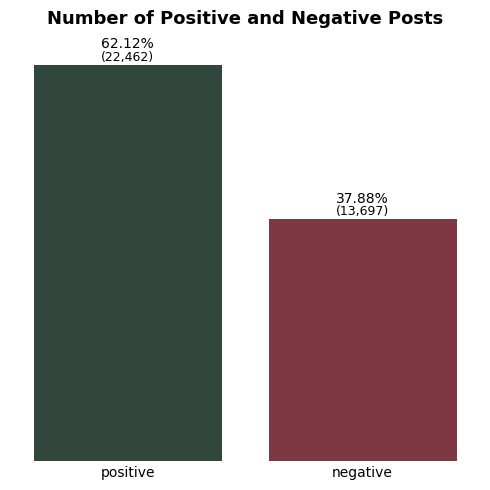

In [16]:
hue='sentiment_label'

visualizer = DataDistributionVisualizer(
    dataframe=df_analysis, 
    figsize=(5, 5), 
    title = f'Number of Positive and Negative Posts'
    )

visualizer.plot_category_distribution(
    category_col=hue, 
    palette = ['#2e4b3a', '#8a2c3d']
    )

## Data

In [17]:
sentiment_label_encoder = {
    'negative': 0,
    'positive' : 1,
}

y = df_analysis['sentiment_label'].map(sentiment_label_encoder).values
X = df_analysis['comment'].tolist()

## Pipeline Text
### Clean text

In [18]:
text_cleaning_steps = [
StringCleaner.remove_line_breaks,
StringCleaner.remove_links,
StringCleaner.normalize_dates,
StringCleaner.normalize_currency,
StringCleaner.replace_numbers,
StringCleaner.replace_negations,
StringCleaner.remove_special_characters,
StringCleaner.normalize_whitespace,
StringCleaner.replace_emojis,
StringCleaner.normalize_repetitions,
StringCleaner.remove_accents,
StringCleaner.replace_slang,
]

### Create TF-IDF vectorize, RSLP and Stop words

In [19]:
pt_stopwords = stopwords.words('portuguese')
rslp_stemmer = RSLPStemmer()

# tfidf_vectorizer = TfidfVectorizer(max_features=300, min_df=6, max_df=0.7, stop_words=pt_stopwords)
tfidf_vectorizer = TfidfVectorizer(max_features=5000, min_df=3, max_df=0.85, ngram_range=(1,2))

### Pipeline

In [20]:
best_params_xgb_binary_cv = {
"random_state": 42,
"verbosity": 0,
"eval_metric": "logloss", 
"objective": "binary:logistic",
'learning_rate': 0.07636873934570003,
 'n_estimators': 900,
 'max_depth': 7,
 'max_delta_step': 7,
 'min_child_weight': 4,
 'subsample': 0.8103837483917693,
 'colsample_bytree': 0.5600827056827629,
 'gamma': 1.685337451172175,
 'reg_lambda': 0.04054723434908615,
 'alpha': 0.30735682609814957
 }


In [21]:
pipeline_full_tfidf_binary = Pipeline([
    ('StringCleanerTransformer', StringCleanerTransformer(text_cleaning_steps)),
    ('StopwordFilter', StopwordFilter(pt_stopwords)),
    ('StemmerTransformer', StemmerTransformer(rslp_stemmer)),
    ('TextVectorizerWrapper', TextVectorizerWrapper(tfidf_vectorizer)),
    ('model', xgb.XGBClassifier(**best_params_xgb_binary_cv))
])

## Boost Hypterparametres

In [22]:
# tuner = HyperparameterTuner(
#     features=X, 
#     labels=y, 
#     pipeline=pipeline_full_tfidf_binary,
#     use_cross_validation=True,
# )
# best_params_lgb, best_value_lgb = tuner.run()

In [23]:
# train_model_classic = ClassifierMetricsEvaluator(model=pipeline_full_tfidf_binary)
# cv_scores, X_train_cv, y_cv, y_pred_cv, y_proba_cv = train_model_classic.cross_validate(X=X, y=y)
# cv_scores

In [24]:
# select_model = 'tfidf_binary'
# joblib.dump(pipeline_full_tfidf_binary, f'{folder}pipeline_{select_model}.joblib')

In [25]:
# plotter = ClassificationVisualizer(
#     true_labels=y_cv,
#     predicted_labels=y_pred_cv,
#     predicted_probabilities=y_proba_cv,
#     features=X_train_cv,
#     model=pipeline_full_tfidf_binary
# )

# plotter.plot_selected_charts(
#     cols = 2,
#     charts = [
#         'confusion_matrix',
#         'roc_curve',
#         'precision_recall_curve',
#         'probability_distribution',
#         'calibration_curve',
#     ]
# )

In [26]:
pipeline_full_bert_binary = Pipeline([
    ('RegexCleanerTransformer', StringCleanerTransformer(text_cleaning_steps)),
    ('StopwordRemover', StopwordFilter(pt_stopwords)),
    ('StemmerTransformer', StemmerTransformer(rslp_stemmer)),
    ('BertEmbeddingTransformer', BertEmbeddingTransformer(batch_size=8, max_length=128)),
    ('model', xgb.XGBClassifier(**best_params_xgb_binary_cv))# ainda mais leve
])

In [ ]:
train_model_classic = ClassifierMetricsEvaluator(model=pipeline_full_bert_binary)
cv_scores, X_train_cv, y_cv, y_pred_cv, y_proba_cv = train_model_classic.cross_validate(X=X, y=y)
cv_scores

Starting cross-validation...


Cross-validation:   0%|          | 0/5 [00:00<?, ?it/s]

Processing fold 1/5...
Starting transformation in StringCleanerTransformer...
Finished transformation in StringCleanerTransformer.
Starting transformation in StopwordFilter...
Finished transformation in StopwordFilter.
Starting transformation in StemmerTransformer...


In [ ]:
select_model = 'bert_binary'
joblib.dump(pipeline_full_bert_binary, f'{folder}pipeline_{select_model}.joblib')

In [ ]:
plotter = ClassificationVisualizer(
    true_labels=y_cv,
    predicted_labels=y_pred_cv,
    predicted_probabilities=y_proba_cv,
    features=X_train_cv,
    model=pipeline_full_bert_binary
)

plotter.plot_selected_charts(
    cols = 2,
    charts = [
        'confusion_matrix',
        'roc_curve',
        'precision_recall_curve',
        'probability_distribution',
        'calibration_curve',
    ]
)

In [ ]:
break

In [ ]:
def plot_sentiment_prediction(input_text, pipeline):
    """
    Plot a sentiment prediction result from a loaded sklearn pipeline.

    Args:
        input_text (str or list of str): Text input(s) to classify.
        pipeline: A fitted sklearn Pipeline including preprocessing and classifier.
    """
    if isinstance(input_text, str):
        input_text = [input_text]

    # Predict using the full pipeline
    predictions = pipeline.predict(input_text)
    probabilities = pipeline.predict_proba(input_text)

    # Output formatting
    sentiment = "Positive" if predictions[0] == 1 else "Negative"
    color = "green" if sentiment == "Positive" else "red"

    confidence = 100 * round(probabilities[0][1 if predictions[0] == 1 else 0], 2)

    # Plot
    fig, ax = plt.subplots(figsize=(3, 1))
    ax.set_title(f'Sentiment Analysis: {confidence:.2f}%', fontsize=14, fontweight='bold')
    ax.text(0.5, 0.0, sentiment, fontsize=50, ha='center', color=color)
    ax.axis('off')

    plt.show()

In [ ]:
select_model = 'tfidf_binary' #  bert_binary

trained_pipeline = joblib.load(f"{folder}pipeline_{select_model}.joblib")

In [ ]:
comment = 'Péssimo produto! Não compro nessa loja, a entrega atrasou e custou muito dinheiro!'
plot_sentiment_prediction(comment, trained_pipeline)

In [ ]:
comment = 'Adorei e realmente cumpriu as expectativas. Comprei por um valor barato. Maravilhoso'
plot_sentiment_prediction(comment, trained_pipeline)

In [ ]:
comment = 'Não sei gostei do produto. O custo foi barato mas veio com defeito. Se der sorte, vale a pena'
plot_sentiment_prediction(comment, trained_pipeline)

In [ ]:
comment = 'Vendedor confiável, produto ok e entrega antes do prazo.'
plot_sentiment_prediction(comment, trained_pipeline)

In [ ]:
def plot_sentiment_prediction(input_text, text_pipeline, tfidf_vectorizer, classifier_model):

    if isinstance(input_text, str):
        input_text = [input_text]

    
    preprocessed_texts = text_pipeline.fit_transform(input_text)
    text_features = tfidf_vectorizer.transform(preprocessed_texts)
    
    feature_names = tfidf_vectorizer.get_feature_names_out()
    
    X_test = pd.DataFrame(text_features.toarray(), columns=feature_names)
    
    # Predict sentiment and probability
    predictions = classifier_model.predict(X_test)
    probabilities = classifier_model.predict_proba(X_test)


    sentiment = "Positive" if predictions[0] == 1 else "Negative"
    color = "green" if sentiment == "Positive" else "red"
    
    confidence = 100 * round(probabilities[0][1 if predictions[0] == 1 else 0], 2)
    
    fig, ax = plt.subplots(figsize=(3, 1))
    
    ax.set_title(f'Sentiment Analysis: {confidence:.2f}%', fontsize=14, fontweight='bold')
    ax.text(0.5, 0.0, sentiment, fontsize=50, ha='center', color=color)
    ax.axis('off')
    
    plt.show()

In [ ]:
def get_word_counter_by_label(df, label_col, text_col, target_label):
    comments = df.query(f'{label_col} == "{target_label}"')[text_col].dropna().tolist()
    words = ' '.join(comments).split()
    return Counter(words)

In [ ]:
positive_dict = get_word_counter_by_label(df_analysis, 'sentiment_label', 'comment', 'positive')
negative_dict = get_word_counter_by_label(df_analysis, 'sentiment_label', 'comment', 'negative')
# neutral_dict = get_word_counter_by_label(df_analysis, 'sentiment_label', 'comment', 'neutral')

In [ ]:

def generate_wordcloud(freq_dict, colormap='Greens'):
    return WordCloud(
        width=1280,
        height=720,
        collocations=False,
        random_state=42,
        colormap=colormap,
        background_color='white',
        max_words=50
    ).generate_from_frequencies(freq_dict)
    
def plot_wordclouds(word_counters, colormaps=None):
    labels = list(word_counters.keys())
    n_labels = len(labels)
    colormaps = colormaps or ['Greys'] * n_labels

    fig, axs = plt.subplots(1, n_labels, figsize=(6 * n_labels, 8))

    # Garante que axs seja iterável mesmo para 1 subplot
    if n_labels == 1:
        axs = [axs]

    for ax, label, cmap in zip(axs, labels, colormaps):
        wc = generate_wordcloud(word_counters[label], colormap=cmap)
        ax.imshow(wc)
        ax.axis('off')
        ax.set_title(f'{label.capitalize()} Words', fontsize=20, fontweight='bold')

    plt.tight_layout()
    plt.show()

In [ ]:
word_counters = {
    'positive': positive_dict,
    'negative': negative_dict,
    # 'neutral': neutral_dict  # se houver
}

colormaps = ['Greens', 'Reds', 'YlOrBr']  # uma para cada label, na mesma ordem

plot_wordclouds(word_counters, colormaps)

# MultiClass

In [ ]:
sentiment_label = {
    1: 'negative',
    2: 'negative',
    3: 'neutral',
    4: 'positive',
    5: 'positive'
}
df_analysis['sentiment_label'] = df_analysis['score'].map(sentiment_label)

In [ ]:
hue='sentiment_label'

visualizer = EDAVisualizer(
    dataframe=df_analysis, 
    figsize=(5, 5), 
    title = f'Number of Positive and Negative Posts'
    )

visualizer.plot_categorical_distribution(
    category_col=hue, 
    palette = ['#2e4b3a', '#8a2c3d', '#caa038']
    )

## Pipeline Text

### Clean text

In [ ]:
text_cleaning_steps = [
TextCleaner.remove_line_breaks,
TextCleaner.remove_links,
TextCleaner.normalize_dates,
TextCleaner.normalize_currency,
TextCleaner.replace_numbers,
TextCleaner.replace_negations,
TextCleaner.remove_special_characters,
TextCleaner.normalize_whitespace,
# TextCleaner.replace_emojis,
# TextCleaner.normalize_repetitions,
# TextCleaner.remove_accents,
# TextCleaner.replace_slang,
]

### Create TF-IDF vectorize, RSLP and Stop words

In [ ]:
pt_stopwords = stopwords.words('portuguese')
rslp_stemmer = RSLPStemmer()

tfidf_vectorizer = TfidfVectorizer(max_features=300, min_df=6, max_df=0.7, stop_words=pt_stopwords)

In [ ]:
text_pipeline_classic = Pipeline([
    ('RegexCleanerTransformer', TextCleanerTransformer(text_cleaning_steps)),
    ('StopwordRemover', StopwordRemover(pt_stopwords)),
    ('StemmerTransformer', StemmerTransformer(rslp_stemmer)),
    ('TextVectorizerWrapper', TextVectorizerWrapper(tfidf_vectorizer))
])

In [ ]:
sentiment_label_encoder = {
    'negative': 0,
    'positive' : 1,
    'neutral': 2,
}

y = df_analysis['sentiment_label'].map(sentiment_label_encoder).values

In [ ]:
X = text_pipeline_classic.fit_transform(df_analysis['comment'].tolist())

In [ ]:
# vectorizer = text_pipeline_classic.named_steps['TextVectorizer'].vectorizer
# feature_names = vectorizer.get_feature_names_out()

# X = pd.DataFrame(X, columns=feature_names)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

### Boost Hypterparametres

In [ ]:
# tuner = ClassificationHyperTuner(
#     X_train=X_train, 
#     y_train=y_train, 
#     X_test=X_test,
#     y_test=y_test, 
#     model_name='xgb', 
#     # use_cv=True,
#     # use_smote=True
# )

# best_params_lgb, best_value_lgb = tuner.run_optimization()

In [ ]:
best_params_xgb_multiclass = {
    "random_state": 42,
    "verbosity": 0,
    "eval_metric": "mlogloss", 
    "objective": "multi:softprob",
    "num_class": 3,
    
    'learning_rate': 0.06313907879950859,
    'n_estimators': 857,
    'max_depth': 10,
    'max_delta_step': 8,
    'min_child_weight': 4,
    'subsample': 0.7483131161847982,
    'colsample_bytree': 0.8785629307217026,
    'gamma': 0.7365922466769782,
    'reg_lambda': 0.28183971758993853,
    'alpha': 0.2155180217081268
 }

In [ ]:
model_classic = xgb.XGBClassifier(**best_params_xgb_multiclass)

pipeline_final = ImbPipeline([
    ('model', model_classic)
])

train_model_classic = ClassifierMetricsEvaluator(model=pipeline_final)

In [ ]:
cv_scores, X_train_cv, y_cv, y_pred_cv, y_proba_cv = train_model_classic.cross_validate(X=X, y=y)
cv_scores

In [ ]:
# joblib.dump(text_pipeline_classic, f'{folder}text_pipeline_classic.joblib')
# joblib.dump(model_classic, f'{folder}classifier_classic.joblib')

In [ ]:
plotter = ClassificationPlotter(
    true_labels=y_cv,
    predicted_labels=y_pred_cv,
    predicted_probabilities=y_proba_cv,
    features=X_train_cv,
    model=pipeline_final
)

plotter.plot_selected_charts(
    charts = [
        'confusion_matrix',
        'roc_curve',
        'precision_recall_curve',
        'probability_distribution',
        'calibration_curve',
    ]
)

In [ ]:
lgb_calibrated = CalibratedClassifierCV(
    estimator=model_classic, 
    method='isotonic', # sigmoid   isotonic
    cv=5,
    # n_jobs=-1
)

smote = SMOTE(
    random_state=42,
    sampling_strategy='not majority'
)

In [ ]:
pipeline_final = ImbPipeline([
    ('smote', smote),
    ('model', lgb_calibrated)
])

train_xgb = ClassifierMetricsEvaluator(model=pipeline_final)

In [ ]:
cv_scores, X_train_cv, y_cv, y_pred_cv, y_proba_cv = train_xgb.cross_validate(X=X, y=y)
cv_scores

In [ ]:
plotter = ClassificationPlotter(
    true_labels=y_cv,
    predicted_labels=y_pred_cv,
    predicted_probabilities=y_proba_cv,
    features=X_train_cv,
    model=pipeline_final
)

plotter.plot_selected_charts(
    charts = [
        'confusion_matrix',
        'roc_curve',
        'precision_recall_curve',
        'probability_distribution',
        'calibration_curve',
    ]
)

---

In [ ]:
# text_pipeline_new = Pipeline([
#     ('RegexCleanerTransformer', TextCleanerTransformer(text_cleaning_steps)),
#     ('StopwordRemover', StopwordRemover(pt_stopwords)),
#     ('BertEmbeddingTransformer', BertEmbeddingTransformer(batch_size=4, max_length=128))  # ainda mais leve
# ])
# X = text_pipeline_new.fit_transform(df_analysis['comment'].tolist())

In [ ]:
# X = text_pipeline_new.fit_transform(df_analysis['comment'].tolist())

In [ ]:
# model = xgb.XGBClassifier(**best_params_xgb_multiclass)

# pipeline_final = ImbPipeline([
#     ('model', model)
# ])

# train_model = ClassifierMetricsEvaluator(model=pipeline_final)

In [ ]:
# cv_scores, X_train_cv, y_cv, y_pred_cv, y_proba_cv  = train_model.cross_validate(X=X, y=y)
# cv_scores 

In [ ]:
# plotter = ClassificationPlotter(
#     true_labels=y_cv,
#     predicted_labels=y_pred_cv,
#     predicted_probabilities=y_proba_cv,
#     features=X_train_cv,
#     model=pipeline_final
# )

# plotter.plot_selected_charts(
#     charts = [
#         'confusion_matrix',
#         'roc_curve',
#         'precision_recall_curve',
#         'probability_distribution',
#         'calibration_curve',
#     ]
# )

In [ ]:
# joblib.dump(text_pipeline_new, 'models/text_pipeline_new.joblib')
# joblib.dump(model, 'models/classifier_new.joblib')